In [1]:
from IPython.display import clear_output

In [2]:
%pip install matplotlib
%pip install shapefile
%pip install requests
%pip install Basemap
%pip install numpy
%matplotlib qt
clear_output()

In [1]:
from mpl_toolkits.basemap import Basemap
from IPython.display import clear_output
from io import BytesIO, StringIO
import matplotlib.patches as pts
import matplotlib.pyplot as plt
import shapefile as spf
import tifffile as tiff
import pandas as pd
import numpy as np
import requests

In [2]:
url_VDL = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/main/data_VDL.tif'

response = requests.get(url_VDL)
response.raise_for_status()

tif_data = BytesIO(response.content)
tif_image = tiff.imread(tif_data)

In [5]:
url_GMMRD = 'https://github.com/LanceryH/NASA-hackathon-2024/raw/main/data_GMMRD.asc'

response = requests.get(url_GMMRD)
response.raise_for_status()

asc_data = StringIO(response.text)

def read_asc(file_like):
    header_lines = 6
    for _ in range(header_lines):
        file_like.readline()
        
    asc_image = np.loadtxt(file_like)
    return asc_image

asc_image = read_asc(asc_data)


In [6]:
print(asc_image.shape)
print(tif_image.shape)

(3430, 8633)
(43200, 86400, 3)


In [3]:
# Define chunk size and starting points
chunk_size = 5000
start_row, start_col = 9000, 13000
end_row, end_col = 19000, 28000 

lat_min, lat_max = -90, 90   # Latitude range for the whole image
lon_min, lon_max = -180, 180 # Longitude range for the whole image

In [4]:
def read_chunk(tif_image, start_row, start_col, end_row, end_col):
    return tif_image[start_row:end_row, start_col:end_col]

def convert_2_cyl(start_row, start_col, end_row, end_col, image_shape):
    image_height, image_width = image_shape
    return [(start_col * 360 / image_width) - 180,
            (end_col * 360 / image_width) - 180,
            -(end_row * 180 / image_height) + 90,
            -(start_row * 180 / image_height) + 90]


In [5]:
chunk_image = read_chunk(tif_image, start_row, start_col, end_row, end_col)

In [6]:
extent_for_tif = convert_2_cyl(start_row, start_col, end_row, end_col, tif_image.shape[:2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


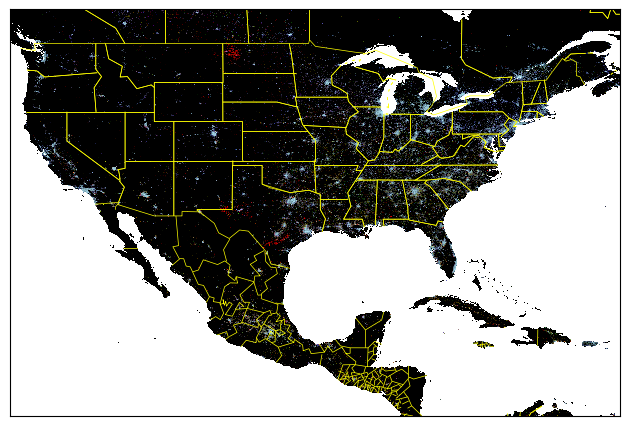

In [7]:
plt.figure()
m = Basemap(projection='cyl',
                llcrnrlat=extent_for_tif[2], urcrnrlat=extent_for_tif[3],
                llcrnrlon=extent_for_tif[0], urcrnrlon=extent_for_tif[1])
m.drawcountries(color="yellow")
m.drawstates(color="yellow")
# m.drawcoastlines(color="yellow")
plt.imshow(chunk_image, extent=extent_for_tif, interpolation='none')
plt.tight_layout()
plt.show()

In [24]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parse the XML file
tree = ET.parse('GDP_PPP.xml')
root = tree.getroot()

# Extract years and GDP values
years = []
gdp = []

# Loop through each record to extract year and value
for record in root.findall('data/record'):
    country_elem = record.find('field[@name="Country or Area"]')
    year_elem = record.find('field[@name="Year"]')
    value_elem = record.find('field[@name="Value"]')
    
    if (country_elem.text == "United States"):
        try:
            year = int(year_elem.text)
            value = float(value_elem.text) if value_elem.text else np.nan
            if not np.isnan(value):
                years.append(year)
                gdp.append(value)
        except ValueError:
            continue
    
# Define exponential model
def function(t, GDP_0, r):
    return GDP_0 * np.exp(r * (t - years[0]))

# Fit the model to the data
popt, pcov = curve_fit(function, years, gdp, p0=(gdp[0], 0.03))
GDP_0, r = popt

print (GDP_0, r)

24944.741006202687 0.03399809392616013


In [33]:
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
from PIL import Image

# Define the exponential model function
def function(t, GDP_0, r, t0):
    """Exponential growth model function."""
    return GDP_0 * np.exp(r * (t - t0))

# Step 1: Load an example image and convert to grayscale
image = Image.open('nike.jpg').convert('L')  # Load image and convert to grayscale
image_array = np.array(image) / 255.0  # Normalize the image to [0, 1]

# Step 2: Use the fitted parameters from your model
GDP_0 = 12345  # Replace this with the value from curve_fit
r = 0.03       # Replace this with the value from curve_fit
t0_x = t0_y = 0  # Assuming 0 as the reference for both axes

# Step 3: Create 1D kernels for both axes
years_x = np.linspace(0, image_array.shape[1], image_array.shape[1])  # Simulating time points for the x-axis
years_y = np.linspace(0, image_array.shape[0], image_array.shape[0])  # Simulating time points for the y-axis

exp_kernel_x = function(years_x, GDP_0, r, t0_x)  # Kernel for x-axis
exp_kernel_y = function(years_y, GDP_0, r, t0_y)  # Kernel for y-axis

# Step 4: Create a 2D kernel by combining the 1D kernels (outer product)
exp_kernel_2d = np.outer(exp_kernel_y, exp_kernel_x)

# Step 5: Normalize the 2D kernel to [0, 1]
exp_kernel_2d /= np.max(exp_kernel_2d)

# Step 6: Perform FFT-based convolution
fft_image = fft2(image_array)
fft_kernel = fft2(exp_kernel_2d, s=image_array.shape)  # Pad kernel to match image size

fft_convolved = fft_image * fft_kernel
convolved_image = np.real(ifft2(fft_convolved))

# Step 7: Normalize the convolved image
convolved_image = convolved_image / np.max(convolved_image)

# Step 8: Clip the result to the [0, 1] range
convolved_image = np.clip(convolved_image, 0, 1)

# Step 9: Display the original and convolved images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title('Convolved Image (2D Exponential Kernel)')

plt.show()
